In [1]:
%matplotlib inline

from src.tables_and_figures import retrive_results, final_results_df

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def make_plot(plot_df):
    plot_df["Fairness"] = plot_df["test_fairness mean"]
    plot_df["Accuracy"] = plot_df["test_performance mean"]

    figure = plt.figure(figsize=(6, 6), dpi = 150) 
    with sns.axes_style("white"):
        sns.lineplot(
            data=plot_df,
            x="Accuracy",
            y="Fairness",
            hue="Models",
            markers=True,
            style="Models",
        )

# Moji

In [3]:
Moji_results = retrive_results("Moji")
Moji_results["FairBatch"] = Moji_results["OldFairBatch"]
Moji_results["Augmented Adv"] = Moji_results["GatedAdv"]
Moji_results["Augmented DAdv"] = Moji_results["GatedDAdv"]

In [4]:
Moji_results.keys()

dict_keys(['Adv', 'BTEO', 'BTFairBatch', 'BTGatedAdv', 'DAdv', 'FairBatch', 'FairSCL', 'GatedAdv', 'GatedBTEO', 'GatedDAdv', 'GDEO', 'GDMean', 'INLP', 'OldFairBatch', 'Vanilla', 'Augmented Adv', 'Augmented DAdv'])

In [5]:
Moji_main_results = final_results_df(
    results_dict = Moji_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "Augmented Adv", "Augmented DAdv", "GDEO", "GDMean", "FairSCL"],
    pareto = False,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True,
    # Fairness_threshold=0.95,
    # return_conf=True,
    save_conf_dir=r"D:\Project\Fair_NLP_Classification\analysis\reproduce\Moji"
    )
Moji_main_results

,Models,test_performance mean,test_performance std,test_fairness mean,test_fairness std,dev_performance mean,dev_performance std,dev_fairness mean,dev_fairness std,DTO
0,Vanilla,0.722981,0.004576,0.611870,0.014356,0.726650,0.003673,0.632302,0.013370,0.476849
1,Adv,0.756414,0.007271,0.893286,0.005623,0.747425,0.004549,0.912125,0.008507,0.265936
2,DAdv,0.755464,0.004076,0.904023,0.011218,0.748550,0.002405,0.915601,0.005007,0.262697
3,INLP,0.733433,NaN,0.855982,NaN,0.727625,NaN,0.859686,NaN,0.302983
4,FairBatch,0.750638,0.006012,0.905537,0.005046,0.744525,0.004995,0.917734,0.004761,0.266655
5,BTEO,0.753927,0.001433,0.877469,0.003756,0.746325,0.000998,0.896874,0.005401,0.274892
6,GatedBTEO,0.762106,0.002592,0.900764,0.014701,0.759775,0.003798,0.909445,0.006631,0.257762
7,Augmented Adv,0.753113,0.005196,0.890065,0.013302,0.748975,0.003805,0.910838,0.010314,0.270257
8,Augmented DAdv,0.750163,0.006945,0.908679,0.021678,0.745600,0.004828,0.928670,0.022488,0.266004
9,GDEO,0.752763,0.004999,0.892255,0.007860,0.749350,0.003494,0.912672,0.002766,0.269694


In [6]:
print(Moji_main_results.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
        Models &  test\_performance mean &  test\_performance std &  test\_fairness mean &  test\_fairness std &  dev\_performance mean &  dev\_performance std &  dev\_fairness mean &  dev\_fairness std &      DTO \\
\midrule
       Vanilla &               0.722981 &              0.004576 &            0.611870 &           0.014356 &              0.726650 &             0.003673 &           0.632302 &          0.013370 & 0.476849 \\
           Adv &               0.756414 &              0.007271 &            0.893286 &           0.005623 &              0.747425 &             0.004549 &           0.912125 &          0.008507 & 0.265936 \\
          DAdv &               0.755464 &              0.004076 &            0.904023 &           0.011218 &              0.748550 &             0.002405 &           0.915601 &          0.005007 & 0.262697 \\
          INLP &               0.733433 &                   NaN &            0.855982 &                NaN &  

In [7]:
tmp_df = Moji_main_results[["Models", "test_performance mean", "test_fairness mean"]].copy()
tmp_df["test_GAP mean"] = 1-tmp_df["test_fairness mean"].copy()
tmp_df[["Models", "test_performance mean", "test_GAP mean"]]

,Models,test_performance mean,test_GAP mean
0,Vanilla,0.722981,0.388130
1,Adv,0.756414,0.106714
2,DAdv,0.755464,0.095977
3,INLP,0.733433,0.144018
4,FairBatch,0.750638,0.094463
5,BTEO,0.753927,0.122531
6,GatedBTEO,0.762106,0.099236
7,Augmented Adv,0.753113,0.109935
8,Augmented DAdv,0.750163,0.091321
9,GDEO,0.752763,0.107745


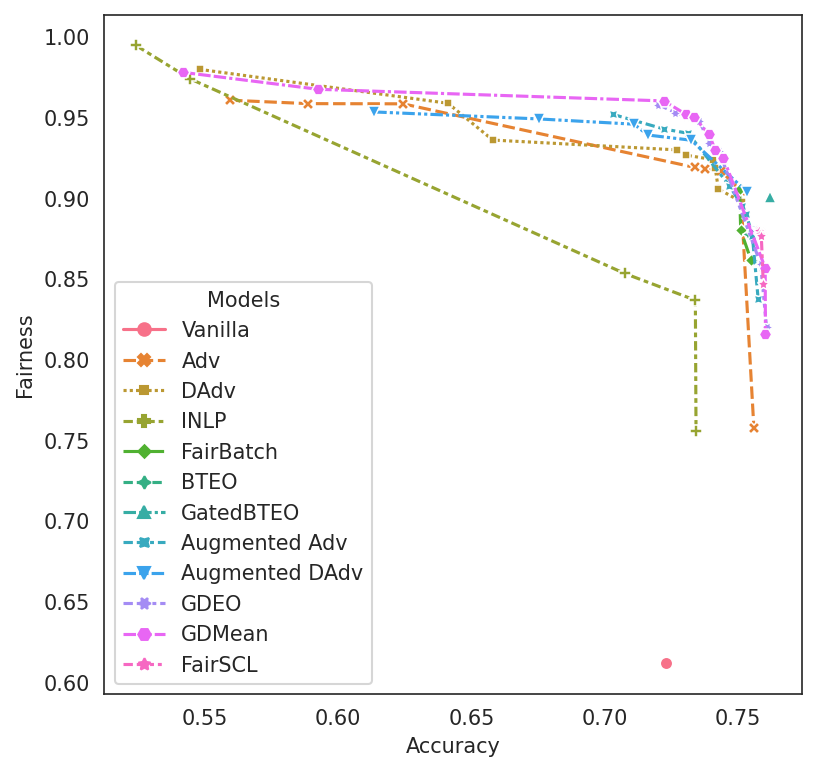

In [28]:
Moji_plot_df = final_results_df(
    results_dict = Moji_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "Augmented Adv", "Augmented DAdv", "GDEO", "GDMean", "FairSCL"],
    pareto = True,
    # pareto = False,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True,
    num_trail=20,
    )

make_plot(Moji_plot_df)

# Bios Intersectional Groups

In [9]:
Bios_both_results = retrive_results("Bios_both")

In [10]:
Bios_both_results["FairBatch"] = Bios_both_results["OldFairBatch"]
Bios_both_results["GatedAdv"] = pd.concat([Bios_both_results["GAdv"], Bios_both_results["BTGAdv"]])
Bios_both_results["GatedDAdv"] = pd.concat([Bios_both_results["GDAdv"], Bios_both_results["BTGDAdv"]])

In [11]:
Bios_both_main_results = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = True
    )
Bios_both_main_results

,Models,test_performance mean,test_performance std,test_fairness mean,test_fairness std,dev_performance mean,dev_performance std,dev_fairness mean,dev_fairness std,DTO
0,Vanilla,0.815181,0.002435,0.555411,0.029533,0.807466,0.002962,0.540741,0.011691,0.481475
1,Adv,0.646016,0.045083,0.836838,0.011231,0.638627,0.043760,0.799317,0.030209,0.389777
2,DAdv,0.680895,0.054854,0.794713,0.067696,0.675794,0.054582,0.754632,0.066709,0.379435
3,INLP,0.813543,NaN,0.624426,NaN,0.803395,NaN,0.543710,NaN,0.419311
4,FairBatch,0.812416,0.001241,0.623468,0.018890,0.805002,0.001388,0.578378,0.014323,0.420671
5,GatedAdv,0.698492,0.035838,0.792417,0.059961,0.692470,0.036704,0.744349,0.035828,0.366057
6,GatedDAdv,0.699038,0.019692,0.797145,0.047948,0.693967,0.020421,0.741946,0.034637,0.362944


In [12]:
Bios_both = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    return_dev = False,
    Fairness_threshold=0.5,
    Performance_threshold=0.7,
    )

In [13]:
print(Bios_both.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
   Models &  test\_performance mean &  test\_performance std &  test\_fairness mean &  test\_fairness std &      DTO \\
\midrule
  Vanilla &               0.815181 &              0.002435 &            0.555411 &           0.029533 & 0.481475 \\
      Adv &               0.715314 &              0.056697 &            0.673155 &           0.053544 & 0.433444 \\
     DAdv &               0.734351 &              0.037638 &            0.687555 &           0.049055 & 0.410111 \\
     INLP &               0.813543 &                   NaN &            0.624426 &                NaN & 0.419311 \\
FairBatch &               0.812416 &              0.001241 &            0.623468 &           0.018890 & 0.420671 \\
 GatedAdv &               0.708736 &              0.050729 &            0.736469 &           0.079803 & 0.392789 \\
GatedDAdv &               0.707055 &              0.041894 &            0.771136 &           0.035268 & 0.371746 \\
\bottomrule
\end{tabular}


In [14]:
Bios_both_results["Augmented Adv"] = Bios_both_results["GatedAdv"]
Bios_both_results["Augmented DAdv"] = Bios_both_results["GatedDAdv"]

In [15]:
Bios_both_plot_df = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "Augmented Adv", "Augmented DAdv"],
    pareto = True,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True
    )

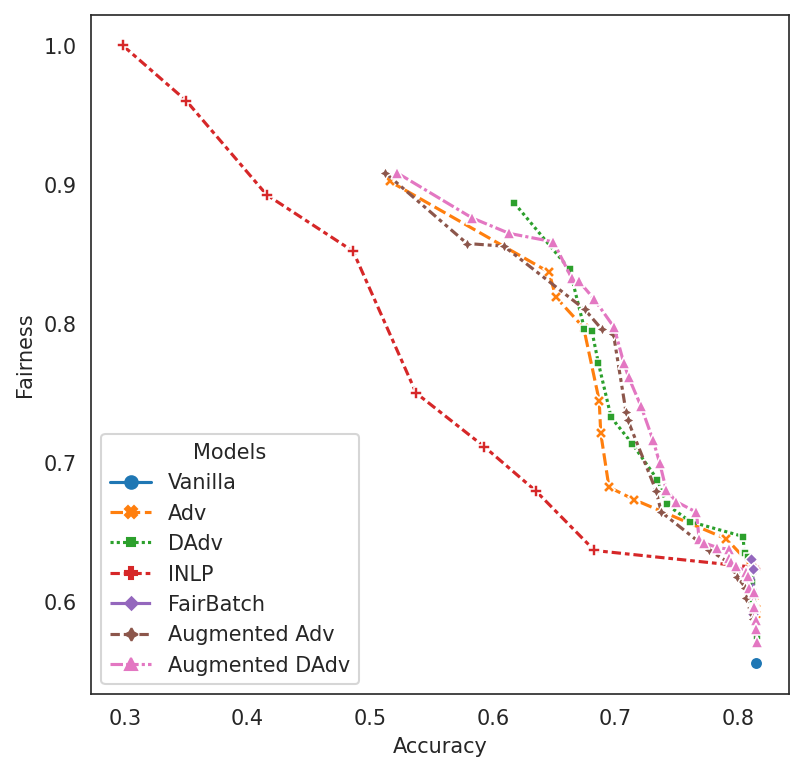

In [16]:
make_plot(Bios_both_plot_df)

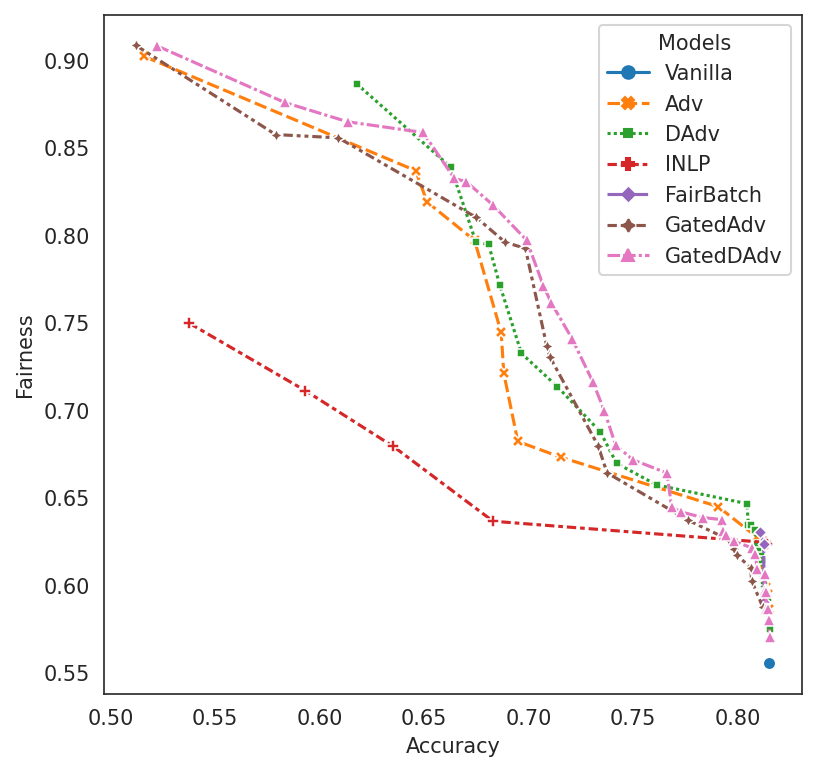

In [17]:
Bios_both_plot_df2 = final_results_df(
    results_dict = Bios_both_results,
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "GatedAdv", "GatedDAdv"],
    pareto = True,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True,
    Fairness_threshold=0.5,
    Performance_threshold=0.5,
    )

make_plot(Bios_both_plot_df2)

# Bios Gender

In [18]:
Bios_gender_results = retrive_results("Bios_gender")

Bios_gender_results["FairBatch"] = Bios_gender_results["OldFairBatch"]
Bios_gender_results["Augmented Adv"] = pd.concat([Bios_gender_results["GAdv"], Bios_gender_results["BTGAdv"]])
Bios_gender_results["Augmented DAdv"] = pd.concat([Bios_gender_results["GDAdv"], Bios_gender_results["BTGDAdv"]])

In [19]:
Bios_gender_results.keys()

dict_keys(['Adv', 'BTEO', 'BTFairBatch', 'BTGAdv', 'BTGDAdv', 'DAdv', 'FairBatch', 'FairSCL', 'GAdv', 'GatedBTEO', 'GDAdv', 'GDEO', 'GDMean', 'INLP', 'OldFairBatch', 'Vanilla', 'Augmented Adv', 'Augmented DAdv'])

In [20]:
Bios_gender_results["GDEO"]

,epoch,dev_fairness,dev_performance,dev_DTO,test_fairness,test_performance,test_DTO,opt_dir
DyBTalpha,,,,,,,,
0.001778,8,0.880611,0.820771,0.001473,0.871154,0.823416,0.000833,/data/cephfs/punim0478/xudongh1/experimental_r...
0.014125,4,0.914531,0.802785,0.015005,0.921416,0.806488,0.010759,/data/cephfs/punim0478/xudongh1/experimental_r...
0.014125,16,0.910311,0.801423,0.015202,0.898125,0.802138,0.021465,/data/cephfs/punim0478/xudongh1/experimental_r...
0.001585,0,0.875468,0.821023,0.001166,0.863463,0.823578,0.009410,/data/cephfs/punim0478/xudongh1/experimental_r...
0.100000,17,0.974083,0.687831,0.007449,0.973082,0.685300,0.010046,/data/cephfs/punim0478/xudongh1/experimental_r...
...,...,...,...,...,...,...,...,...
0.005623,18,0.902017,0.819459,0.001322,0.881040,0.820812,0.024292,/data/cephfs/punim0478/xudongh1/experimental_r...
0.003981,15,0.880674,0.818299,0.005216,0.868637,0.821609,0.006063,/data/cephfs/punim0478/xudongh1/experimental_r...
0.070795,1,0.958956,0.722466,0.019352,0.952466,0.721931,0.029682,/data/cephfs/punim0478/xudongh1/experimental_r...


In [21]:
Bios_gender_main_results = final_results_df(
    results_dict = Bios_gender_results,
    # model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "GatedAdv", "GatedDAdv"],
    model_order =["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "Augmented Adv", "Augmented DAdv", "GDEO", "GDMean", "FairSCL"],
    pareto = True,
    pareto_selection = "test",
    selection_criterion = "DTO",
    # return_dev = True,
    # save_conf_dir = r"D:\Project\Fair_NLP_Classification\analysis\reproduce\Bios_gender"
    )
Bios_gender_main_results

,Models,test_performance mean,test_performance std,test_fairness mean,test_fairness std,dev_performance mean,dev_performance std,dev_fairness mean,dev_fairness std,DTO
0,Vanilla,0.822512,0.002410,0.851071,0.008095,0.819908,0.002125,0.863145,0.006457,0.231694
1,Adv,0.816637,0.002187,0.907356,0.007686,0.814308,0.001234,0.909428,0.008285,0.205438
2,DAdv,0.818480,0.001898,0.906376,0.004832,0.815252,0.001580,0.910746,0.006586,0.204242
3,INLP,0.823032,NaN,0.886249,NaN,0.820670,NaN,0.883876,NaN,0.210373
4,FairBatch,0.822382,0.001280,0.894995,0.012474,0.819868,0.001111,0.906735,0.001468,0.206335
5,BTEO,0.838326,0.002492,0.905370,0.009064,0.837228,0.002927,0.901765,0.009754,0.187332
6,GatedBTEO,0.836682,0.002266,0.904041,0.009154,0.833613,0.002738,0.894495,0.004687,0.189422
7,Augmented Adv,0.823037,0.002191,0.883569,0.008850,0.820226,0.002073,0.888371,0.007412,0.211830
8,Augmented DAdv,0.819136,0.003358,0.889603,0.005943,0.816541,0.003499,0.898678,0.007902,0.211894
9,GDEO,0.817773,0.002688,0.888683,0.009449,0.815024,0.003022,0.898779,0.010683,0.213537


In [22]:
tmp_df = Bios_gender_main_results[["Models", "test_performance mean", "test_fairness mean"]].copy()
tmp_df["test_GAP mean"] = 1-tmp_df["test_fairness mean"].copy()
tmp_df[["Models", "test_performance mean", "test_GAP mean"]]

,Models,test_performance mean,test_GAP mean
0,Vanilla,0.822512,0.148929
1,Adv,0.816637,0.092644
2,DAdv,0.818480,0.093624
3,INLP,0.823032,0.113751
4,FairBatch,0.822382,0.105005
5,BTEO,0.838326,0.094630
6,GatedBTEO,0.836682,0.095959
7,Augmented Adv,0.823037,0.116431
8,Augmented DAdv,0.819136,0.110397
9,GDEO,0.817773,0.111317


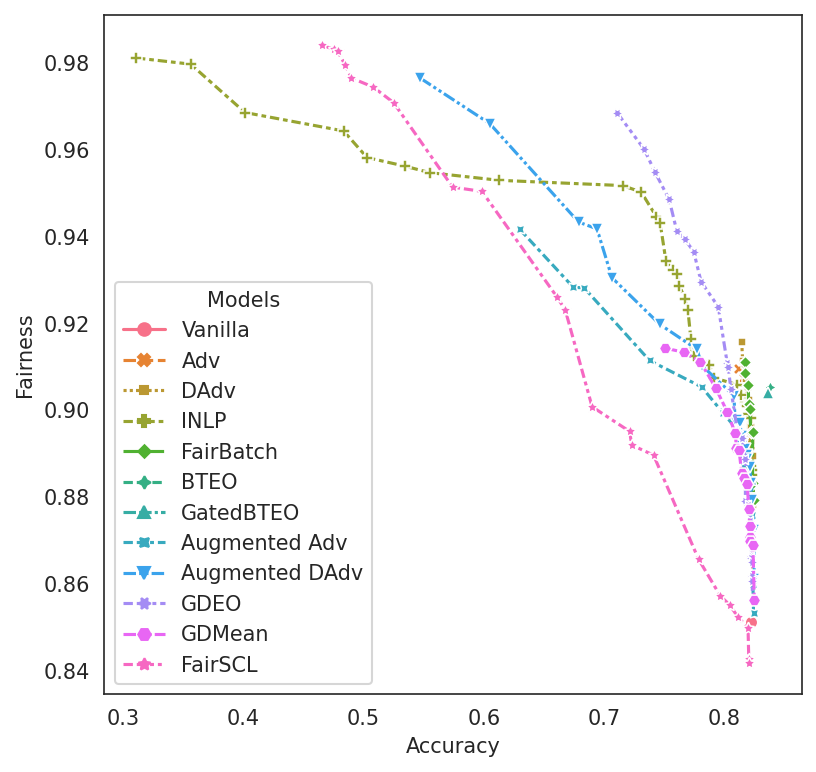

In [34]:
Bios_gender_plot_df = final_results_df(
    results_dict = Bios_gender_results,
    # model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "GatedAdv", "GatedDAdv"],
    model_order = ["Vanilla", "Adv", "DAdv", "INLP", "FairBatch", "BTEO", "GatedBTEO", "Augmented Adv", "Augmented DAdv", "GDEO", "GDMean", "FairSCL"],
    pareto = True,
    # pareto = False,
    pareto_selection = "test",
    selection_criterion = None,
    return_dev = True,
    Fairness_threshold=0.8,
    # Performance_threshold=0.5,
    # num_trail=1
    )

make_plot(Bios_gender_plot_df)